In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/gefan/Projects/scoreoperator


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ml_collections import ConfigDict
import diffrax as drx

from src.data.butterflies import Butterfly
from src.models.nerualop.FNO import UNO1D
from src.models.diffusion.diffusion import DiffusionLoader
from src.models.diffusion.sde import BrownianSDE
from src.models.diffusion.gaussian_process import GaussianProcess
from src.utils.trainer import TrainerModule
from src.utils.plotting import plot_shape_with_pts, plot_trajectories
from src.utils.util import save_config, load_config

2024-04-16 16:39:30.723970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 16:39:30.724009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 16:39:30.725427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 16:39:31.826160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


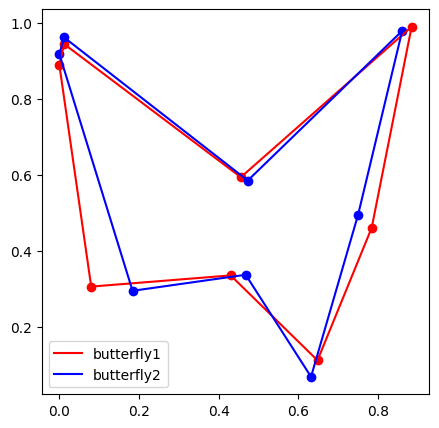

In [14]:
butterfly1 = Butterfly("example_butterfly1")
butterfly2 = Butterfly("example_butterfly2")

n_training_sample_pts = 8
butterfly1_sample = butterfly1.sample(n_training_sample_pts)
butterfly2_sample = butterfly2.sample(n_training_sample_pts)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plot_shape_with_pts(ax, butterfly1_sample, color="r", label="butterfly1")
ax = plot_shape_with_pts(ax, butterfly2_sample, color="b", label="butterfly2")
ax.legend()

In [15]:
config = ConfigDict()

# Gaussian process
config.gp = ConfigDict()
config.gp.input_dim = 1
config.gp.output_dim = 2
config.gp.n_sample_pts = n_training_sample_pts
config.gp.kernel_type = "delta"
config.gp.sigma = 1.0

# SDE
config.sde = ConfigDict()
config.sde.sigma = 0.05

# FNO
config.model = ConfigDict()
config.model.out_co_dim = 2
config.model.lifting_dim = 32
config.model.co_dims_fmults = [1, 2, 4, 4]
config.model.n_modes_per_layer = [4, 4, 2, 2]
config.model.act = "gelu"
norm = "batch"

# training
config.training = ConfigDict()
config.training.seed = 42
config.training.learning_rate = 2e-3
config.training.optimizer_name = "adam"
config.training.warmup_steps = 2000
config.training.train_batch_size = 64
config.training.train_num_epochs = 100
config.training.train_num_steps_per_epoch = 200
config.training.train_num_steps_per_epoch = 300


In [16]:
# config = load_config("./pretrained/configs/butterflies.yaml")

In [17]:
model = UNO1D(**config.model)
gp = GaussianProcess(**config.gp)
sde = BrownianSDE(**config.sde, gp=gp)

In [18]:
diffusion_loader = DiffusionLoader(
    sde, 
    seed=config.training.seed,
    init_cond=jnp.zeros_like(butterfly1_sample),
    batch_size=config.training.train_batch_size,
    n_steps=100)

trainer = TrainerModule(
    config=config.training,
    model=model,
    dataloader=diffusion_loader,
    enable_wandb=False
)

In [19]:
trainer.train_model(
    pretrained=False,
    load_dir="/home/gefan/Projects/scoreoperator/src/pretrained",
    prefix=f"butterfly_brownian_64pts_training100",
)

Training: 100%|██████████| 100/100 [05:32<00:00,  3.33s/epoch, Epoch=99, eval_loss=0.2442, train_loss=0.3268]


In [20]:
def true_brownian_score(t, x, x0=butterfly1_sample):
    mean, std = sde._transition_prob(t, x, x0)
    return  -(x - mean) / (std + 1e-4)**2

def est_brownian_score(t, x, x0=butterfly1_sample):
    x_ = jnp.expand_dims(x, axis=0)
    t_ = jnp.expand_dims(t, axis=0)
    score = trainer.infer_model((x_, t_)) / (jnp.sqrt(t + 1e-4) * config.sde.sigma)
    return score.squeeze() 

In [21]:
class ReverseBrownianSDE(BrownianSDE):
    def __init__(self, sigma, gp, score_fn):
        super().__init__(gp, sigma)
        self._score_fn = score_fn

    def f(self, t, x):
        return  self._sigma**2 * self._score_fn(1.0 - t, x)
    
    def g(self, t, x):
        return self._sigma * jnp.eye(x.shape[0])

In [22]:
n_eval_sample_pts = 120
score_fn = lambda t, x: est_brownian_score(t, x.reshape(-1, 2)).flatten()
# score_fn = lambda t, x: true_brownian_score(t, x.reshape(-1, 2), x0=jnp.zeros_like(butterfly1.sample(n_eval_sample_pts))).flatten()

gp._n_sample_pts = n_eval_sample_pts
reverse_sde = ReverseBrownianSDE(sigma=config.sde.sigma, gp=gp, score_fn=score_fn)

In [23]:
drift = lambda t, y, args: reverse_sde.f(t, y)
diffusion = lambda t, y, args: reverse_sde.g(t, y)
brownian_motion = drx.VirtualBrownianTree(t0=0.0, t1=1.0, tol=1e-3, shape=((2*n_eval_sample_pts,)), key=jax.random.PRNGKey(4))
terms = drx.MultiTerm(drx.ODETerm(drift), drx.ControlTerm(diffusion, brownian_motion))
solver = drx.Euler()
saveat = drx.SaveAt(ts=jnp.linspace(0.0, 1.0, 500))
sol = drx.diffeqsolve(terms, solver, 0.0, 1.0, 1e-3, butterfly2.sample(n_eval_sample_pts).flatten(), saveat=saveat)